# Определение стоимости автомобилей

## Задача

Владельцы сервиса по продаже автомобилей с пробегом разрабатывают приложение для привлечения новых клиентов. В нём пользователь сможет быстро узнать рыночную стоимость своего автомобиля на основе информации, которую он предоставит. Требуется построить модель, которая будет предсказывать эту стоимость. Нам даны исторические данные: технические характеристики, комплектации и цены автомобилей. RMSE модели должен быть меньше 2500. Также важны скорости предсказания и обучения, так что обратим внимание и на эти характеристики наших моделей тоже.

## Подготовка данных

### Подключение библиотек и настройка

In [1]:
%pip install optuna
%pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import time
import pandas as pd

import optuna
from optuna.samplers import TPESampler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

png_renderer = pio.renderers["png"]
png_renderer.width = 1000
png_renderer.height = 500
pio.renderers.default = "png"

### Загрузка и осмотр таблицы

In [3]:
df = pd.read_csv('./datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

354369 вхождений. В данных присутствуют лишние столбцы для нашей задачи, пропуски и аномалии.

### Отбрасываем лишние столбцы

Однозначно лишние столбцы:
- DateCrawled - дата скачивания анкеты из базы.
- LastSeen — дата последней активности пользователя.

Удалим LastSeen. DateCrawled удалим, когда разберёмся со столбцом RegistrationYear.

In [5]:
df = df.drop(['LastSeen'], axis=1)

PostalCode - почтовый индекс владельца анкеты (пользователя).

Теоретически, почтовый индекс продавца зависит от адреса продавца. Регион продажи может зависеть от адреса продавца. А цена на автомобили может зависеть от региона. Но модель разрабатывается для приложения, где пользователи смогут узнать от модели приблизительную стоимость их автомобиля, и вряд ли их в приложении будут спрашивать индекс. Отбрасываем.

In [6]:
df = df.drop(['PostalCode'], axis=1)

NumberOfPictures — количество фотографий автомобиля.

Теоретически, цена автомобиля может зависеть от того, на сколько хорошо владелец представил свой автомобиль в анкете. Но приложение не будет спрашивать пользователя, сколько он планирует выложить фотографий, если будет заполнять анкету. Тоже отбрасываем.

In [7]:
df = df.drop(['NumberOfPictures'], axis=1)

Из данных не понятно, что означает цена. Это цена, которую выставел продавец, или цена реальной продажи? Когда цена была выставлена? Для простоты будем считать, что цена всегда актуальна на данный момент.

DateCreated — дата создания анкеты.

Поскольку мы решили, что цена всегда актуальна, дата создания анкеты не важна. Иначе бы пришлось скармливать модели текущую дату каждый раз, когда пользователь приложения пытается узнать цену своего автомобиля. Отбросим его. Но потом, когда разберёмся со столбцом RegistrationYear.

- RegistrationYear — год регистрации автомобиля.
- RegistrationMonth — месяц регистрации автомобиля.

В данных уже есть отдельный столбец под пробег (Kilometer). Тем не менее, в таблице нет данных о том, когда данная модель поступила в продажу (впрочем, указаны сами марка и модель). Это можно только прикинуть из данных в остальных столбцах. Эти два столбца одни из таких. Продавец не мог зарегистрировать свой автомобиль до того, как эта модель поступила в продажу (но мог сильно после). Оставим столбец с годом регистрации и отбросим столбец с месяцем регистрации, потому что такая детализация избыточна, и отбросив этот столбец мы упростим обучение моделей.

In [8]:
df = df.drop(['RegistrationMonth'], axis=1)

Посмотрим на оставшиеся столбцы.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       354369 non-null  object
 1   Price             354369 non-null  int64 
 2   VehicleType       316879 non-null  object
 3   RegistrationYear  354369 non-null  int64 
 4   Gearbox           334536 non-null  object
 5   Power             354369 non-null  int64 
 6   Model             334664 non-null  object
 7   Kilometer         354369 non-null  int64 
 8   FuelType          321474 non-null  object
 9   Brand             354369 non-null  object
 10  Repaired          283215 non-null  object
 11  DateCreated       354369 non-null  object
dtypes: int64(4), object(8)
memory usage: 32.4+ MB


### Подсчёт пропусков

In [10]:
df.isna().sum()

DateCrawled             0
Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
DateCreated             0
dtype: int64

Пять столбцов содержат пропуски. В целевом признаке пропусков нет.

### Обработка столбцов по отдельности

#### Price

Price — цена в евро. Числовой целевой признак.

Построим Violin-plot.

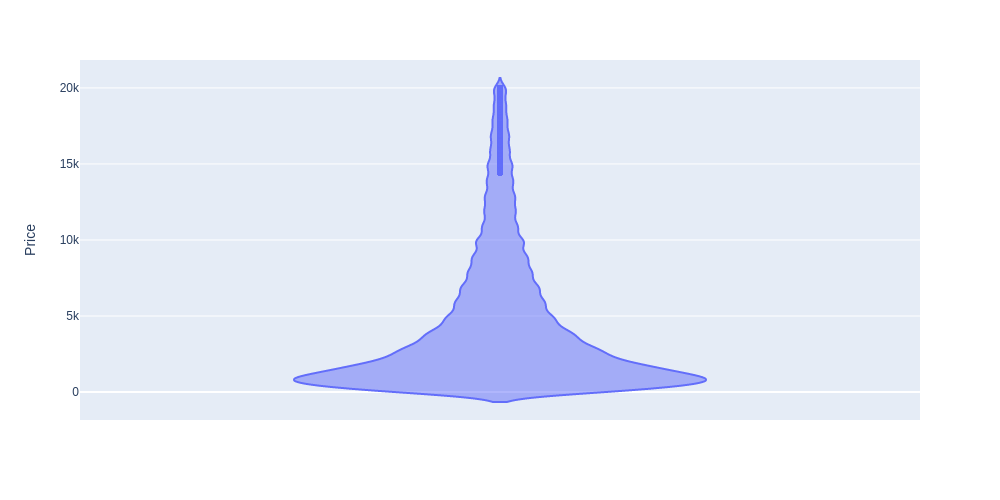

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [11]:
display(px.violin(df, y="Price"))
df['Price'].describe()

Медиана равна 2700 евро, что, наверное, довольно мало. Посчитаем, сколько машин имеют нулевую цену и процент таких машин.

In [12]:
print(df.query('Price == 0').shape[0])
print(df.query('Price == 0').shape[0] / df.shape[0])

10772
0.030397692800442477


Если сравнивать со всем датасетом, то количество небольшое, но заметное. Целых 3%. Построим Violin-plot по всем ценам меньше 2000 евро.

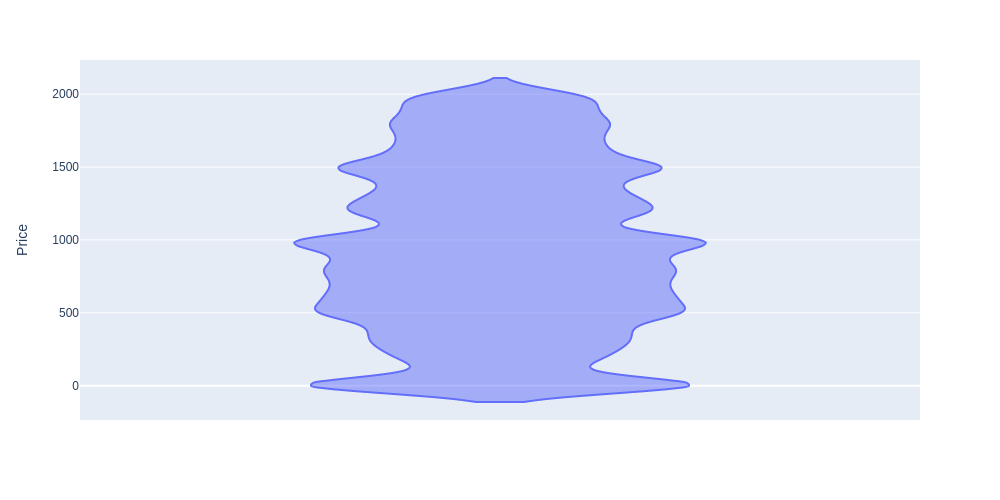

In [13]:
px.violin(df.query('Price < 2000'), y="Price")

Не видно такого, чтобы всё распределение было сосредоточено вокруг какого-то конкретного небольшого значения. Можно увидеть небольшие увеличения плотностей вокруг значений 500, 1000, 1200 и 1500 (возможно, потому что люди любят круглые числа). Но также можно увидеть большое увеличение плотности вокруг нуля. Исключим нули из графика.

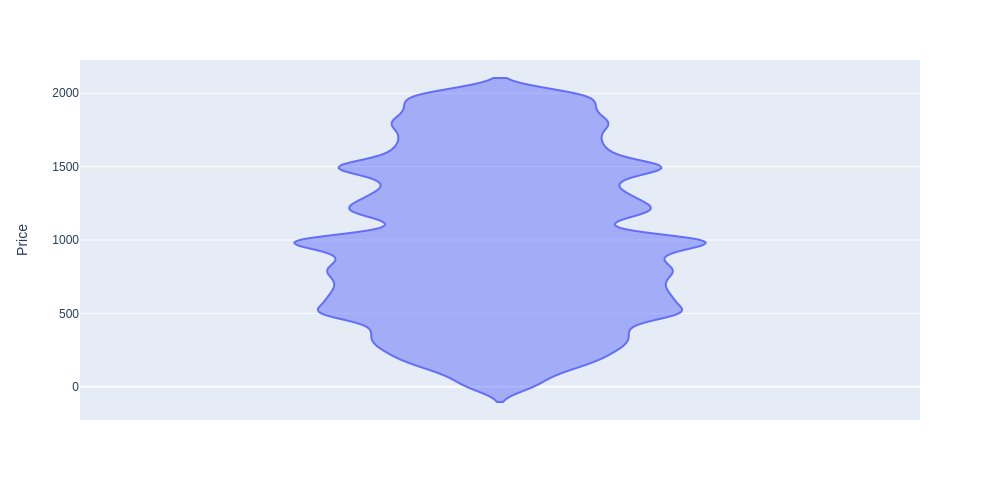

In [14]:
px.violin(df.query('0 < Price < 2000'), y="Price")

Да, это были именно нули. Их всего 3%, но, скорее всего, предсказательная мощь наших итоговых моделей немного увеличится, если удалить записи с нулями из датасета. Так и сделаем.

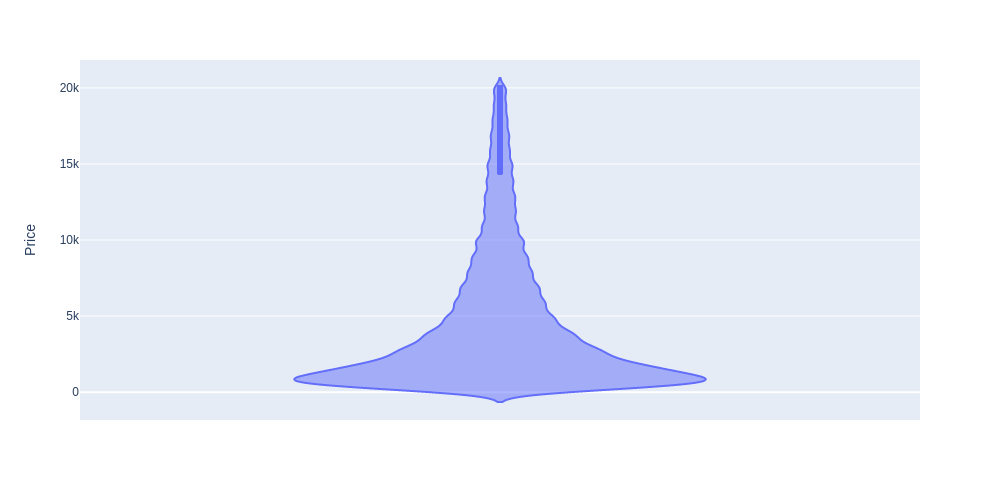

In [15]:
df = df.query('Price > 0')
px.violin(df, y="Price")

Посчитаем количество автомобилей ценой меньше 100 евро.

In [16]:
df.query('Price < 100').shape[0]

2542

Всё-равно присутствуют подозрительно низкие цены включая цены в одно евро, но не ожидается, что эти данные сильно исказят работу модели. Цены, которые отмечены как выбросы, выглядят разумными для некоторых дорогих автомобилей.

Снова посчитаем пропуски после фильтрации.

In [17]:
df.isna().sum()

DateCrawled             0
Price                   0
VehicleType         33750
RegistrationYear        0
Gearbox             17355
Power                   0
Model               17521
Kilometer               0
FuelType            29459
Brand                   0
Repaired            65866
DateCreated             0
dtype: int64

#### Brand

Brand — марка автомобиля. Категориальный признак.

Выведем все уникальные значения и количества вхождений с ними.

In [18]:
df['Brand'].value_counts()

volkswagen        74413
opel              38530
bmw               35809
mercedes_benz     31359
audi              28574
ford              24457
renault           17389
peugeot           10781
fiat               9332
seat               6718
mazda              5465
skoda              5435
smart              5171
citroen            5029
nissan             4807
toyota             4536
hyundai            3533
mini               3165
volvo              3122
mitsubishi         2927
sonstige_autos     2847
honda              2715
kia                2407
suzuki             2273
alfa_romeo         2234
chevrolet          1704
chrysler           1368
dacia               890
daihatsu            775
subaru              735
porsche             734
jeep                658
land_rover          534
daewoo              533
saab                515
trabant             498
jaguar              493
rover               462
lancia              457
lada                213
Name: Brand, dtype: int64

Теперь выведем все значения в алфавитном порядке.

In [19]:
for brand in df['Brand'].sort_values().unique():
    print(brand)

alfa_romeo
audi
bmw
chevrolet
chrysler
citroen
dacia
daewoo
daihatsu
fiat
ford
honda
hyundai
jaguar
jeep
kia
lada
lancia
land_rover
mazda
mercedes_benz
mini
mitsubishi
nissan
opel
peugeot
porsche
renault
rover
saab
seat
skoda
smart
sonstige_autos
subaru
suzuki
toyota
trabant
volkswagen
volvo


Неявных дубликатов не видно. Похоже, всё в порядке.

#### Model

Model — модель автомобиля. Категориальный признак.

Этот столбец с пропусками. Посчитаем их отдельно и вычислим их процент от всего датасета.

In [20]:
print(df['Model'].isna().sum())
print(df['Model'].isna().sum() / df.shape[0])

17521
0.050992878284734734


5%. Довольно много.

Выведем все уникальные значения и количества вхождений с ними.

In [21]:
df['Model'].value_counts()

golf                  28246
other                 23707
3er                   19179
polo                  12628
corsa                 12197
                      ...  
serie_2                   8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 250, dtype: int64

250 разных моделей. Выведем их в алфавитном порядке сгруппировав по марке.

In [22]:
for brand in df['Brand'].sort_values().unique():
    brand_df = df.query('Brand == @brand')
    print(f'{brand}: {brand_df.shape[0]}')
    
    for model in df.query('Brand == @brand')['Model'].sort_values().unique():
        if type(model) == float:
            print(f'    {model}: {brand_df["Model"].isna().sum()}')
        else:
            print(f'    {model}: {brand_df.query("Model == @model").shape[0]}')  

alfa_romeo: 2234
    145: 46
    147: 564
    156: 604
    159: 208
    other: 501
    spider: 189
    nan: 122
audi: 28574
    100: 396
    200: 17
    80: 1516
    90: 94
    a1: 593
    a2: 368
    a3: 6026
    a4: 9642
    a5: 534
    a6: 5368
    a8: 516
    other: 1018
    q3: 13
    q5: 97
    q7: 204
    tt: 1066
    nan: 1106
bmw: 35809
    1er: 3497
    3er: 19179
    5er: 7665
    6er: 146
    7er: 986
    i3: 8
    m_reihe: 121
    other: 199
    x_reihe: 1571
    z_reihe: 709
    nan: 1728
chevrolet: 1704
    aveo: 117
    captiva: 167
    matiz: 282
    other: 918
    spark: 123
    nan: 97
chrysler: 1368
    300c: 139
    crossfire: 64
    grand: 110
    other: 369
    ptcruiser: 295
    voyager: 311
    nan: 80
citroen: 5029
    berlingo: 814
    c1: 386
    c2: 391
    c3: 499
    c4: 443
    c5: 477
    other: 1790
    nan: 229
dacia: 890
    duster: 203
    lodgy: 35
    logan: 320
    other: 21
    sandero: 292
    nan: 19
daewoo: 533
    kalos: 95
    lanos: 86
   

    escort: 841
    fiesta: 5656
    focus: 5750
    fusion: 298
    galaxy: 1127
    ka: 2612
    kuga: 317
    mondeo: 3487
    mustang: 172
    other: 1394
    s_max: 431
    transit: 744
    nan: 920
honda: 2715
    accord: 344
    civic: 1297
    cr_reihe: 333
    jazz: 299
    other: 308
    nan: 134
hyundai: 3533
    getz: 413
    i_reihe: 1223
    other: 1138
    santa: 310
    tucson: 230
    nan: 219
jaguar: 493
    other: 189
    s_type: 123
    x_type: 171
    nan: 10
jeep: 658
    cherokee: 162
    grand: 237
    other: 136
    wrangler: 100
    nan: 23
kia: 2407
    carnival: 269
    ceed: 249
    other: 477
    picanto: 362
    rio: 356
    sorento: 339
    sportage: 246
    nan: 109
lada: 213
    kalina: 9
    niva: 126
    other: 54
    samara: 12
    nan: 12
lancia: 457
    delta: 34
    elefantino: 11
    kappa: 15
    lybra: 51
    musa: 23
    other: 99
    ypsilon: 201
    nan: 23
land_rover: 534
    defender: 74
    discovery: 76
    freelander: 210
    other: 18

Кроме пропусков, очевидных проблем не видно.

Конечный пользователь нашего приложения не будет указывать в приложении, что он не знает модель своего автомобиля. Максимум, ему придётся указать "другое". Но это не значит, что мы можем удалить вхождения с пропусками. Их много.

Для решающего дерева и ансамблевых моделей, которые включают в себя решающее дерево (которое работает с входными признаками), это дополнительное возможное значение пропуска увеличит комплексность модели и сложность обучения и работы. Если бы мы заранее знали, что проверка на пропуск будет на самой верхушке дерева, то мы могли бы просто удалить все вхождения с пропусками. Но это маловероятно. Скорее всего дерево будет проверять другие данные, прежде чем столкнётся с проверкой на пропуск, если вообще столкнётся. Оставим вхождения с пропусками.

Некоторые из моделей, с которыми мы будем работать, умеют работать с пропусками. Для них пропуск это лишь отдельное возможное значение. Но не все модели такие. Заменим пропуски на заглушку. Так все модели смогут работать с данными. Модели, которые всё же умеют работать с пропусками должны работать также.

In [23]:
df['Model'] = df['Model'].fillna('unknown')
df['Model'].isna().sum()

0

#### VehicleType

VehicleType — тип автомобильного кузова. Категориальный признак.

Этот столбец с пропусками. Посчитаем их отдельно и вычислим их процент от всего датасета.

In [24]:
print(df['VehicleType'].isna().sum())
print(df['VehicleType'].isna().sum() / df.shape[0])

33750
0.09822553747558914


Почти 10%

Выведем уникальные значения вместе с количеством вхождений для кадого типа.

In [25]:
df['VehicleType'].value_counts()

sedan          89405
small          78018
wagon          63701
bus            28345
convertible    19865
coupe          15636
suv            11791
other           3086
Name: VehicleType, dtype: int64

Нет какого-то очевидного значения, которым можно было бы заполнить пропуски. other не подходит, потому что это означает "ничего из вышеперечисленного", то есть какая-то экзотика.

Заполним пропуски заглушкой.

In [26]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['VehicleType'].value_counts()

sedan          89405
small          78018
wagon          63701
unknown        33750
bus            28345
convertible    19865
coupe          15636
suv            11791
other           3086
Name: VehicleType, dtype: int64

In [27]:
df['VehicleType'].isna().sum()

0

#### RegistrationYear

RegistrationYear — год регистрации автомобиля. Числовой признак.

Построим Violin-plot.

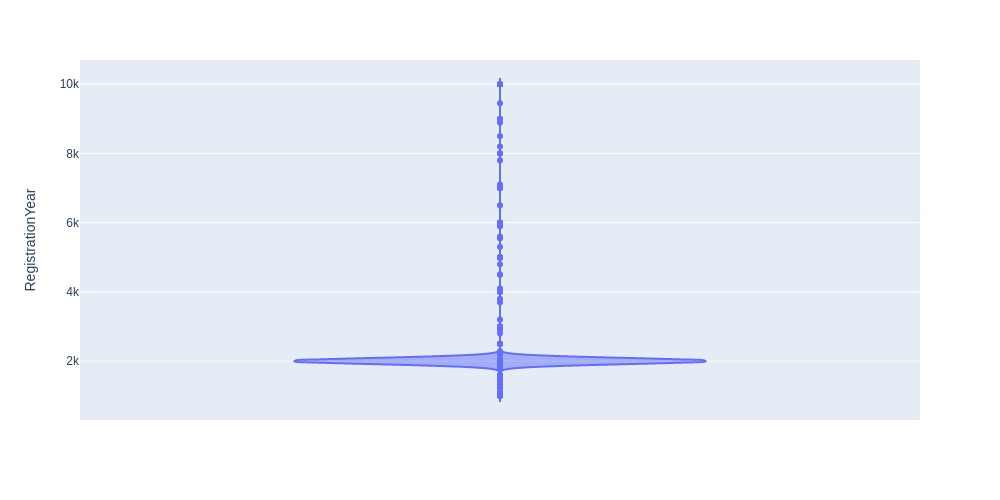

count    343597.000000
mean       2004.089797
std          78.413225
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [28]:
display(px.violin(df, y="RegistrationYear"))
df['RegistrationYear'].describe()

Имеются выбросы. Автомобили не могли быть зарегестрированы после создания анкеты или после того, как анкета была скачана для данного датасета. Сконвертируем столбцы DateCrawled и DateCreated из строки в год.

In [29]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S').dt.year
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S').dt.year

display(df[['DateCrawled', 'DateCreated']].info())
display(df[['DateCrawled', 'DateCreated']].head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   DateCrawled  343597 non-null  int64
 1   DateCreated  343597 non-null  int64
dtypes: int64(2)
memory usage: 7.9 MB


None

,DateCrawled,DateCreated
0,2016,2016
1,2016,2016
2,2016,2016
3,2016,2016
4,2016,2016


Построим Violin-plot по этим двум столбцам, чтобы убедиться, что с ними нет такой же проблемы.

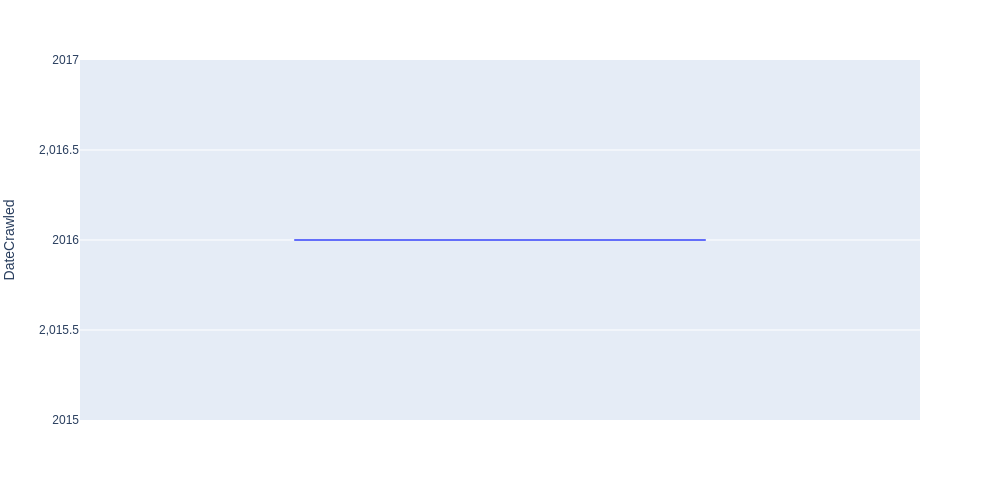

In [30]:
px.violin(df, y="DateCrawled")

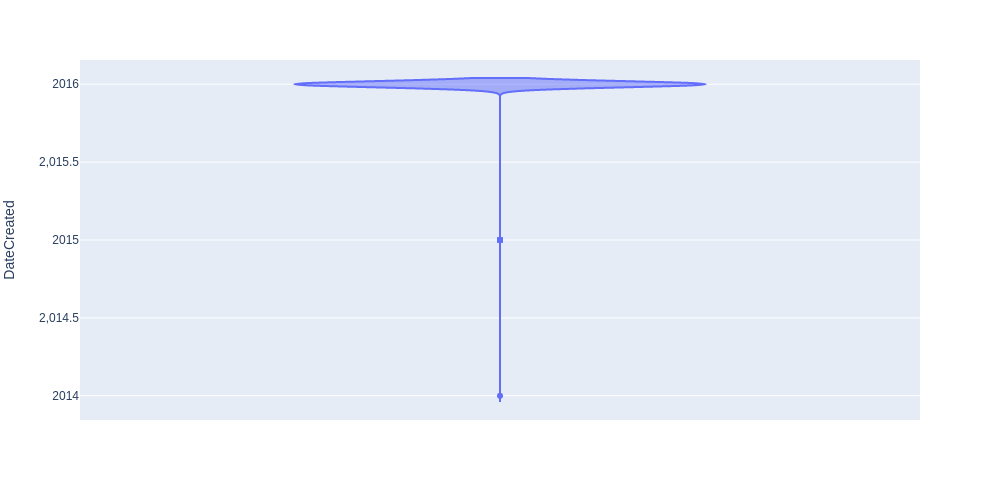

In [31]:
px.violin(df, y="DateCreated")

Все анкеты были скачаны в 2016, и тогда же были созданы почти все анкеты. Автомобили не могли быть зарегестрированы после 2016. Посчитаем количество таких аномальных вхождений и его процент от всего датасета.

In [32]:
print(df.query('RegistrationYear > 2016').shape[0])
print(df.query('RegistrationYear > 2016').shape[0] / df.shape[0])

13779
0.04010221276670052


4%. Заметное количество. А признак важный. Он должен коррелировать с тем, на сколько старая сама модель автомобиля. Но удалять данные не хочется. Даже если значение года регистрации не отражает реальность, то, на сколько старая модель автомобиля, можно прикинуть из пробега или, собственно, модели автомобиля, если она указана. Заменим аномалии на заглушку равную нулю. Мы аналитику не делаем, а натренерованные деревья должны суметь разобраться, хоть это и увеличит комплексность моделей.

In [33]:
s = df['RegistrationYear']
df['RegistrationYear'] = s.mask(s > 2016, 0)

Наконец, можем удалить столбцы DateCrawled и DateCreated.

In [34]:
df = df.drop(['DateCrawled', 'DateCreated'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343597 non-null  int64 
 1   VehicleType       343597 non-null  object
 2   RegistrationYear  343597 non-null  int64 
 3   Gearbox           326242 non-null  object
 4   Power             343597 non-null  int64 
 5   Model             343597 non-null  object
 6   Kilometer         343597 non-null  int64 
 7   FuelType          314138 non-null  object
 8   Brand             343597 non-null  object
 9   Repaired          277731 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.8+ MB


Снова строим Violin-plot по столбцу RegistrationYear.

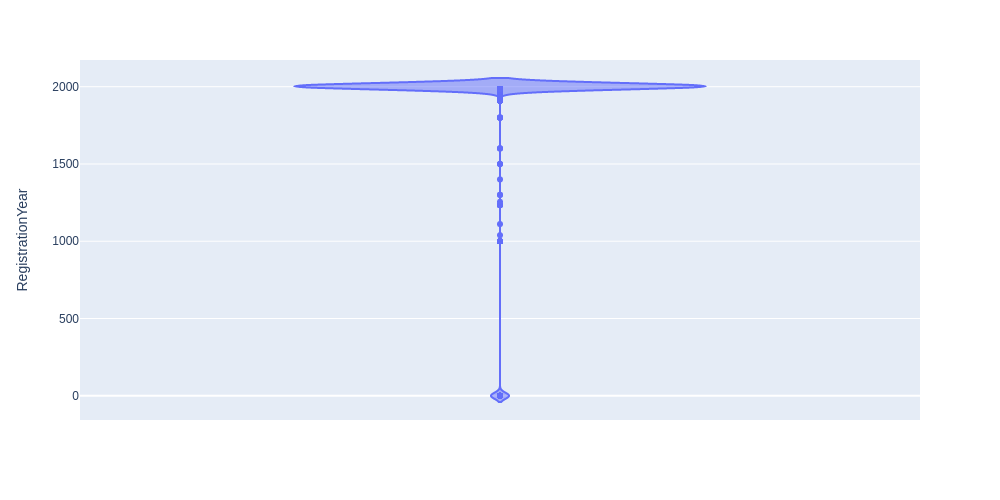

In [35]:
px.violin(df, y="RegistrationYear")

Даже если автомобиль старый и раритетный, то регистрация автомобиля на владельца всё-равно должна происходить в течении жизни владельца. Посчитаем количество регистраций меньше 1950 и его процент от всего датасета.

In [36]:
print(df.query('0 < RegistrationYear < 1950').shape[0])
print(df.query('0 < RegistrationYear < 1950').shape[0] / df.shape[0])

179
0.000520959146907569


Их почти нет. Но всё-равно заменим на заглушку.

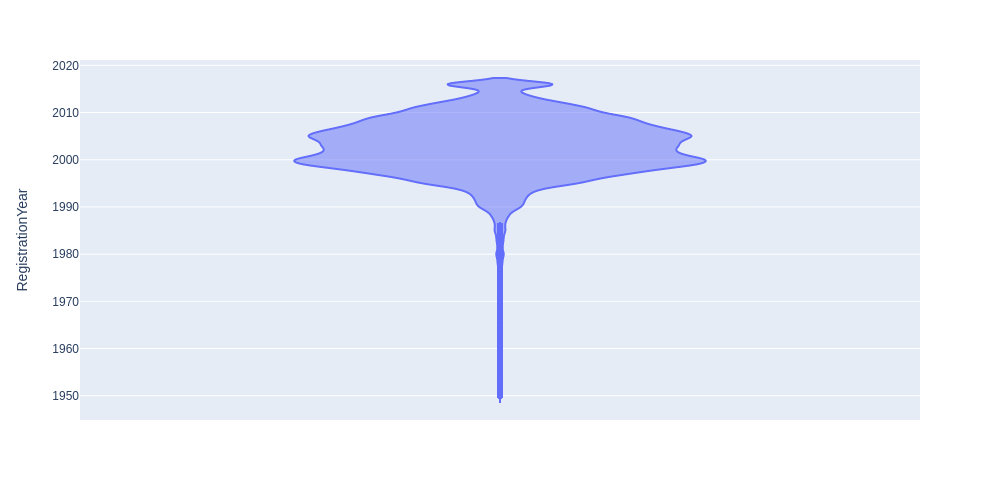

In [37]:
s = df['RegistrationYear']
df['RegistrationYear'] = s.mask(s < 1950, 0)

px.violin(df.query('RegistrationYear != 0'), y="RegistrationYear")

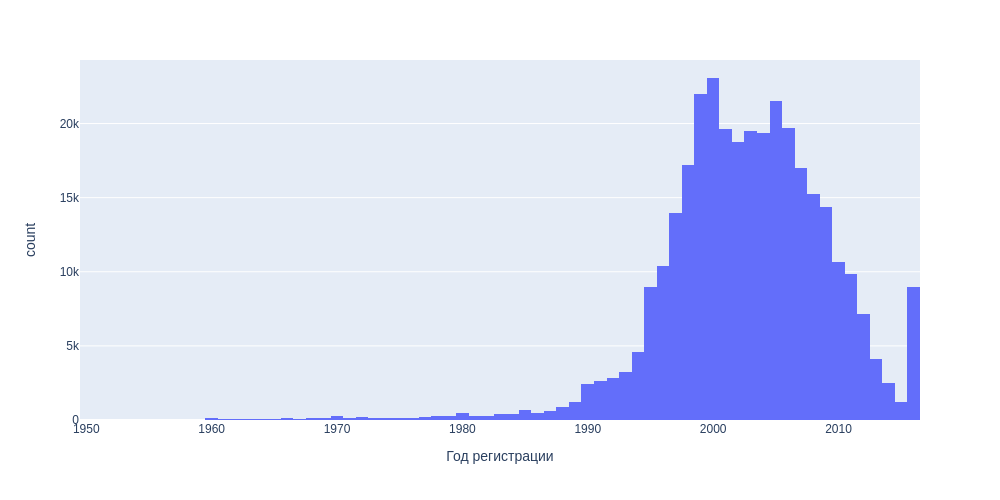

In [38]:
px.histogram(
    df.query('RegistrationYear != 0'),
    x="RegistrationYear",
    labels={'RegistrationYear': 'Год регистрации'}
)

Количество автомобилей, зарегестрированных в 2016 году, сильно увеличено по сравнению с количествами автомобилей, зарегестрированных в ближайших годах до этого. Но это не обязательно ошибка в данных. Это может быть особенностью самого датасета и того, что туда попало.

#### Gearbox

Gearbox — тип коробки передач. Категориальный признак.

Этот столбец с пропусками. Посчитаем их отдельно и вычислим их процент от всего датасета.

In [39]:
print(df['Gearbox'].isna().sum())
print(df['Gearbox'].isna().sum() / df.shape[0])

17355
0.050509754159669615


5% пропусков.

Выведем все уникальные значения и количества вхождений с ними.

In [40]:
df['Gearbox'].value_counts()

manual    261373
auto       64869
Name: Gearbox, dtype: int64

Заполним пропуски заглушкой.

In [41]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Gearbox'].value_counts()

manual     261373
auto        64869
unknown     17355
Name: Gearbox, dtype: int64

In [42]:
df['Gearbox'].isna().sum()

0

#### Power

Power — мощность в лошадиных силах. Числовой признак.

Построим Violin-plot.

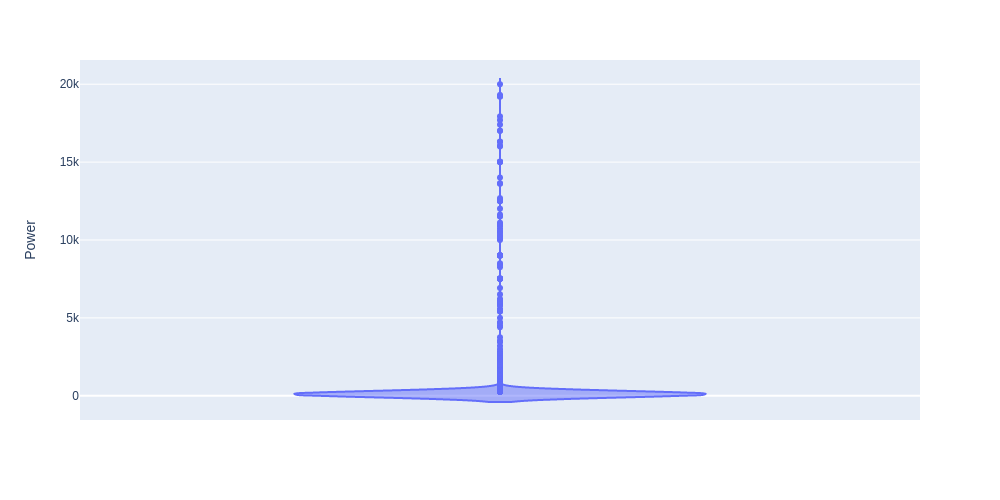

count    343597.000000
mean        111.000192
std         188.177974
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [43]:
display(px.violin(df, y="Power"))
df['Power'].describe()

Имеются выбросы, которые придётся удалить. Параметр важен для цены. Автомобили с мощностью больше 2000 лошадиных сил это редкие суперкары. Посчитаем количество вхождений со значением больше 2000, и процент таких вхождений.

In [44]:
print(df.query('Power > 2000').shape[0])
print(df.query('Power > 2000').shape[0] / df.shape[0])

114
0.0003317840376953233


Их очень мало.

Существуют нулевые значения. Отфильтруем все значения выше 250 и снова построим Violin-plot.

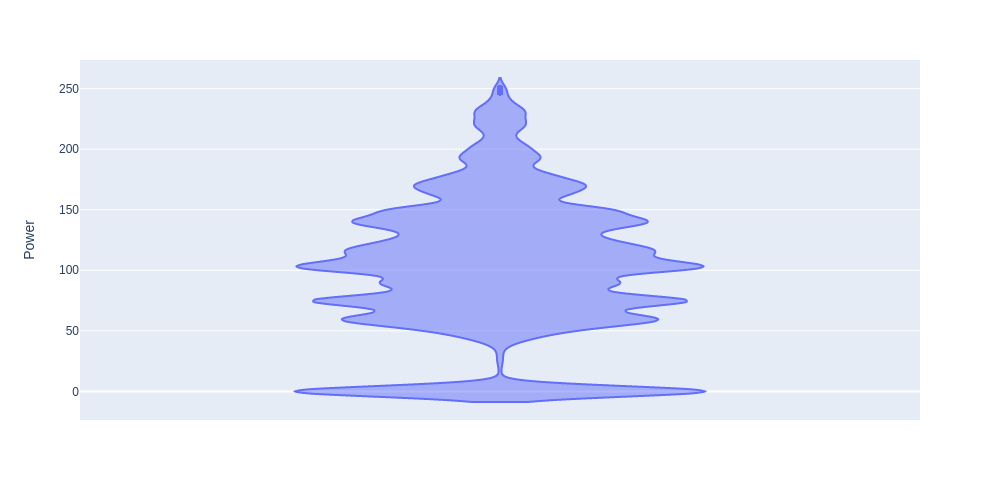

In [45]:
px.violin(df.query('Power <= 250'), y="Power")

Снова видно увеличение плотности вокруг нуля. Посчитаем количество автомобилей с нулевой мощностью и их процент.

In [46]:
print(df.query('Power == 0').shape[0])
print(df.query('Power == 0').shape[0] / df.shape[0])

36360
0.1058216457070347


10% с лишним процентов. Удалять нельзя. Отфильтруем нули тоже и ещё раз построим Violin-plot.

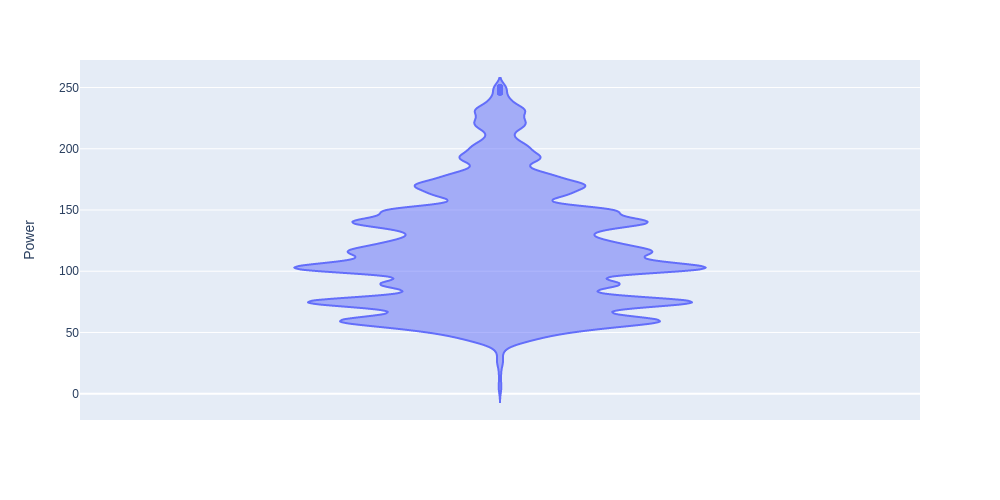

In [47]:
px.violin(df.query('0 < Power <= 250'), y="Power")

Увеличение плотности у нижней границы исчезло.

Нули оставим. Натренерованные деревья должны суметь разобраться. У них будут другие важные параметры, по которым можно будет прикинуть цену. Заполним значения выше 2000 тоже нулями в качестве заглушки.

In [48]:
s = df['Power']
df['Power'] = s.mask(s > 2000, 0)
df.query('Power > 2000').shape[0]

0

#### Kilometer

Kilometer — пробег в километрах. Числовой признак.

Построим Violin-plot.

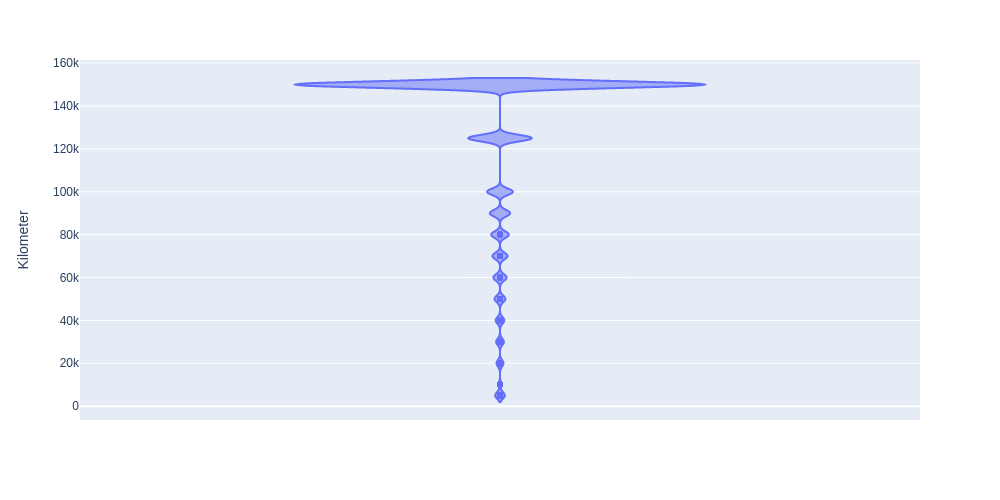

count    343597.000000
mean     128337.616452
std       37521.047429
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [49]:
display(px.violin(df, y="Kilometer"))
df['Kilometer'].describe()

Violin-plot выглядит странно. Возможно, там немного уникальных значений. Выведем все уникальные значения и количества уникальных вхождений с ними.

In [50]:
df['Kilometer'].value_counts().sort_index()

5000        5372
10000       1146
20000       3837
30000       4332
40000       4856
50000       6153
60000       7369
70000       8493
80000       9900
90000      11394
100000     14446
125000     35762
150000    230537
Name: Kilometer, dtype: int64

Похоже, в анкете владельцы выбирали примерный пробег из списка. Причём количество вхождений с минимальным и максимальным пробегом увеличено по сравнению с соседями. То есть "5000" означает "5000 и меньше", а "150000" означает "150000 и больше".

В остальном со столбцом всё в порядке. Будем и дальше относиться к этому признаку как к числовому.

#### FuelType

FuelType — тип топлива. Категориальный признак.

Этот столбец с пропусками. Посчитаем их отдельно и вычислим их процент от всего датасета.

In [51]:
print(df['FuelType'].isna().sum())
print(df['FuelType'].isna().sum() / df.shape[0])

29459
0.08573706988128535


8.6% пропусков.

Выведем все уникальные значения и количества вхождений с ними.

In [52]:
df['FuelType'].value_counts()

petrol      210765
gasoline     97168
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: FuelType, dtype: int64

Заполним пропуски заглушкой.

In [53]:
df['FuelType'] = df['FuelType'].fillna('unknown')
df['FuelType'].value_counts()

petrol      210765
gasoline     97168
unknown      29459
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: FuelType, dtype: int64

In [54]:
df['FuelType'].isna().sum()

0

#### Repaired

Repaired — была машина в ремонте или нет. Категориальный признак.

Этот признак мог быть бинарным, но в нём содержатся пропуски. Посчитаем их отдельно и вычислим их процент от всего датасета.

In [55]:
print(df['Repaired'].isna().sum())
print(df['Repaired'].isna().sum() / df.shape[0])

65866
0.19169550374421196


Целых 19% пропусков.

Выведем все уникальные значения и количества вхождений с ними.

In [56]:
df['Repaired'].value_counts()

no     243682
yes     34049
Name: Repaired, dtype: int64

Всего два уникальных значения, как и должно быть.

Заполним пропуски заглушкой.

In [57]:
df['Repaired'] = df['Repaired'].fillna('unknown')
df['Repaired'].value_counts()

no         243682
unknown     65866
yes         34049
Name: Repaired, dtype: int64

### Итоги

Данные загружены и подготовлены. Лишние столбцы отброшены. Вхождения с нулевой ценой удалены, так как это целевой признак. От удаления остальных вхождений полностью отказались. Пропуски в категориальных признаках заполнили значением "unknown". Аномалии в числовых признаках заполнили нулями. Рассчитываем на то, что модели справятся с таким способом борьбы с пропусками и аномалиями. Зато не потеряли данные. Данных много, но, если их делить на группы по моделям, то среди получающихся групп будут довольно маленькие, а информация о конкретной модели может быть важна, даже если есть аномалии и пропуски в других признаках.

## Обучение моделей

### Разбивка данных

Выделим целевой и известные признаки.

In [58]:
X = df.drop(['Price'], axis=1)
y = df['Price']

print('Известные признаки:')
display(X.head())

print('Целевой признак:')
display(y.head())

Известные признаки:


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Целевой признак:


0      480
1    18300
2     9800
3     1500
4     3600
Name: Price, dtype: int64

Выделим категориальные признаки в отдельный список.

In [59]:
categorical_features = ['Brand', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'Repaired']

Делим данные на тренирочную и тестовую выборки.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0
)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (274877, 9)
X_test shape: (68720, 9)
y_train shape: (274877,)
y_test shape: (68720,)


Проверим распределение целевого признака в обеих выборках.

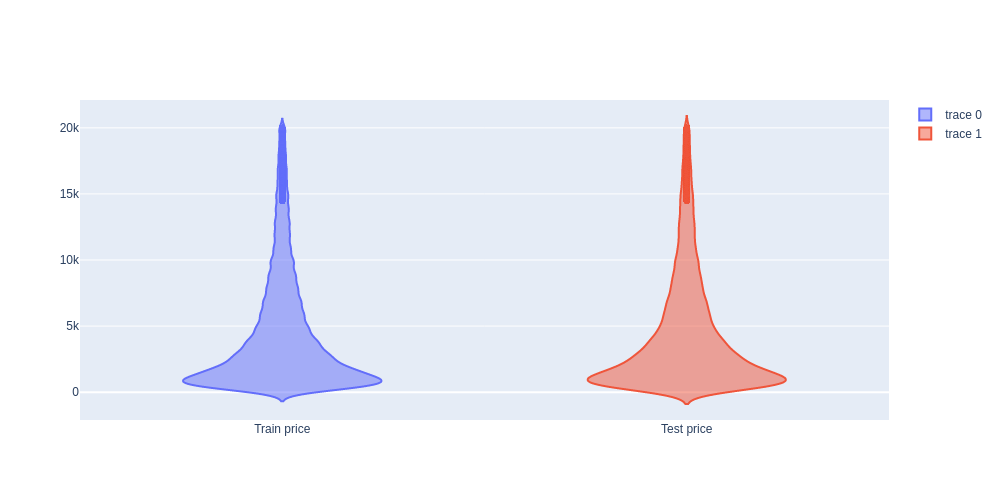

Train price:


count    274877.000000
mean       4562.727016
std        4521.325406
min           1.000000
25%        1200.000000
50%        2899.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Test price:


count    68720.000000
mean      4524.702139
std       4489.807890
min          1.000000
25%       1200.000000
50%       2850.000000
75%       6500.000000
max      20000.000000
Name: Price, dtype: float64

In [61]:
fig = go.Figure()

fig.add_trace(go.Violin(
    y=y_train,
    x0='Train price'
))

fig.add_trace(go.Violin(
    y=y_test,
    x0='Test price'
))

fig.show()

print('Train price:')
display(y_train.describe())

print('Test price:')
y_test.describe()

Распределения похожи.

### Обучение

Обучать будем только модели, в основе которых лежат деревья: решающее дерево, случайный лес (закомментированно) и LightGBM (закомментированно). Используем кроссвалидацию. Подбираем гиперпараметры с помощью Optuna.

In [62]:
%%time

model_creators = {
    'DecisionTreeRegressor': (lambda trial: DecisionTreeRegressor(
        max_depth=trial.suggest_int('max_depth', 1, 20),
        random_state=0,
    )),
    
#     Долгая модель.
#     Лучшие параметры, которые удалось найти: {'max_depth': 20, 'n_estimators': 51}
#     RMSE: 1672.4257564227385
#     'RandomForestRegressor': (lambda trial: RandomForestRegressor(
#         max_depth=trial.suggest_int('max_depth', 1, 20),
#         n_estimators=trial.suggest_int('n_estimators', 20, 100),
#         random_state=0,
#     )),
    
#     Тоже долгая модель. Не работает на GPU.
#     Лучшие параметры, которые удалось найти: {'learning_rate': 0.4375872112626925, 'num_leaves': 28}
#     RMSE: 1701.2930585937934
#     'LGBMRegressor': (lambda trial: LGBMRegressor(
#         learning_rate=trial.suggest_float("learning_rate", 0, 1),
#         num_leaves=trial.suggest_int('num_leaves', 2, 31),
#         random_state=0,
#     )),    
}

def wrap_in_pipeline(model):
    return Pipeline([
        ('OrdinalEncoder', ColumnTransformer(
            [('OrdinalEncoder', OrdinalEncoder(
                handle_unknown='use_encoded_value',
#                 Прямо сейчас у нас выходит так, что категория 'unknown'
#                 и неизвестная категория будут иметь разный код.
                unknown_value=-1
            ), categorical_features)],
            remainder='passthrough'
        )),
        ('model', model)
    ])

def objective(trial):   
    return cross_val_score(
        wrap_in_pipeline(model_creators[current_model](trial)),
        X_train,
        y_train,
        cv=5,
        scoring='neg_root_mean_squared_error'
    ).mean()

for current_model in model_creators:
    study = optuna.create_study(
        study_name=current_model,
        direction='maximize',
        sampler=TPESampler(seed=0)
    )

    study.optimize(objective, n_trials=5)

    print(current_model)
    print(study.best_params)
    print('RMSE:', -study.best_value)

[I 2023-08-12 00:23:28,429] A new study created in memory with name: DecisionTreeRegressor
[I 2023-08-12 00:23:31,871] Trial 0 finished with value: -2016.0658777425742 and parameters: {'max_depth': 11}. Best is trial 0 with value: -2016.0658777425742.
[I 2023-08-12 00:23:35,766] Trial 1 finished with value: -1961.0859408929343 and parameters: {'max_depth': 15}. Best is trial 1 with value: -1961.0859408929343.
[I 2023-08-12 00:23:39,400] Trial 2 finished with value: -1960.8257669434886 and parameters: {'max_depth': 13}. Best is trial 2 with value: -1960.8257669434886.
[I 2023-08-12 00:23:42,889] Trial 3 finished with value: -2016.0658777425742 and parameters: {'max_depth': 11}. Best is trial 2 with value: -1960.8257669434886.
[I 2023-08-12 00:23:46,066] Trial 4 finished with value: -2111.857611002656 and parameters: {'max_depth': 9}. Best is trial 2 with value: -1960.8257669434886.


DecisionTreeRegressor
{'max_depth': 13}
RMSE: 1960.8257669434886
CPU times: user 17.6 s, sys: 8.6 ms, total: 17.6 s
Wall time: 17.6 s


Лучший результат дал случайный лес с гиперпараметрами `{'max_depth': 20, 'n_estimators': 51}` (модель сейчас закомментирована). Средний RMSE на кроссвалидаций равен 1672. Много, при медианной цене в 2700, но для задачи RMSE должен быть хотя бы меньше 2500. Возможно, модель предсказывает слишком низкую цену для очень дорогих авто, и поэтому такой высокий RMSE. Обучение с пятью попытками подобрать гиперпараметры на кроссвалидации с пятью фолдами на выборке из 274877 вхождений длилось 15 минут.

Вторая по качеству модель это LightGBM с гиперпараметрами `{'learning_rate': 0.4375872112626925, 'num_leaves': 28}` (тоже закомментирована). Средний RMSE на кроссвалидации равен 1701. Возможно, можно достичь результата лучше с другими гиперпараметрами. Но модель обучается гораздо дольше. Пять попыток подобрать гиперпараметры длились 52 минуты.

И последняя по качеству модель это решающее дерево с макимальной глубиной 13. Средний RMSE на кроссвалидации равен 1960, что всё ещё достаточно хорошо для задачи. Обучение при таких же условиях длилось всего 13 секунд.

## Анализ моделей

### Отбор моделей с лучшими гиперпараметрами

Создадим словарь, куда добавим по одной модели с лучшими гиперпараметрами для каждого алгоитма обучения, который мы попробовали.

In [63]:
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(
        max_depth=13,
        random_state=0,
    ),
    
    'RandomForestRegressor': RandomForestRegressor(
        max_depth=20,
        n_estimators=51,
        random_state=0,
    ),
    
    'LGBMRegressor': LGBMRegressor(
        learning_rate=0.4375872112626925,
        num_leaves=28,
        random_state=0,
    ),
}

Завернём все модели в пайплайн.

In [64]:
for key, model in models.items():
    models[key] = wrap_in_pipeline(model)

### Время обучения

Натренируем каждую модель на целовй тренировочной выборке и засечём время обучения каждой модели.

In [65]:
def get_time(start):
    seconds = time.perf_counter() - start
    minutes = seconds // 60
    seconds %= 60
    return f'{math.floor(minutes)}:{math.floor(seconds):02}'

print('Количество наблюдений в обучающей выборке:', X_train.shape[0])

for key, model in models.items():
    start = time.perf_counter()
    model.fit(X_train, y_train)
    print(f'{key}: {get_time(start)}')

Количество наблюдений в обучающей выборке: 274877
DecisionTreeRegressor: 0:00
RandomForestRegressor: 0:25
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 274877, number of used features: 9
[LightGBM] [Info] Start training from score 4562.727016
LGBMRegressor: 0:00


Все модели обучались на выборке с 274877 наблюдениями.

- Быстрее всего обучилось решающее дерево. Всего 2 секунды.
- На втором месте - случайный лес. Он обучился за 1 минуту и 14 секунд.
- На третьем месте - LightGBM. 6 минут и 3 секунды.

### Время предсказания

Сгенерируем с помощью моделей предсказания для тестовой выборки и засечём время работы каждой модели.

In [66]:
# %%time
# predictions = model.predict(X_test)

print('Количество наблюдений в тестовой выборке выборке:', X_test.shape[0])

predictions = {}

for key, model in models.items():
    start = time.perf_counter()
    predictions[key] = model.predict(X_test)
    print(f'{key}: {get_time(start)}')

Количество наблюдений в тестовой выборке выборке: 68720
DecisionTreeRegressor: 0:00
RandomForestRegressor: 0:00
LGBMRegressor: 0:00


Все модели делали предсказания для выборки из 68720 наблюдений (в 4 раза меньше тренировочной выборки).

Решающее дерево и LightGBM отработали почти мгновенно. Меньше секунды. Случайный лес медленнее, но тоже быстрый. Две секунды.

### Анализ качества предсказания

Вычислим RMSE для предсказаний каждой модели по тестовой выборке.

In [67]:
for key, prediction in predictions.items():
    print(f'{key} RMSE: {mean_squared_error(y_test, prediction, squared=False)}')

DecisionTreeRegressor RMSE: 1927.5381121294472
RandomForestRegressor RMSE: 1646.9464005312761
LGBMRegressor RMSE: 1682.349160350876


RMSE всех моделей меньше 2500, что удовлетворяет заданию.

- Самый лучший RMSE у случайного леса. RMSE = 1646.95.
- На втором месте - LightGBM. RMSE = 1682.35.
- На третьем месте - решающее дерево. RMSE = 1927.54.

Выберем модель с лучшим RMSE и посмотрим, как она ошибиается. Построим Heatmap по ошибкам.

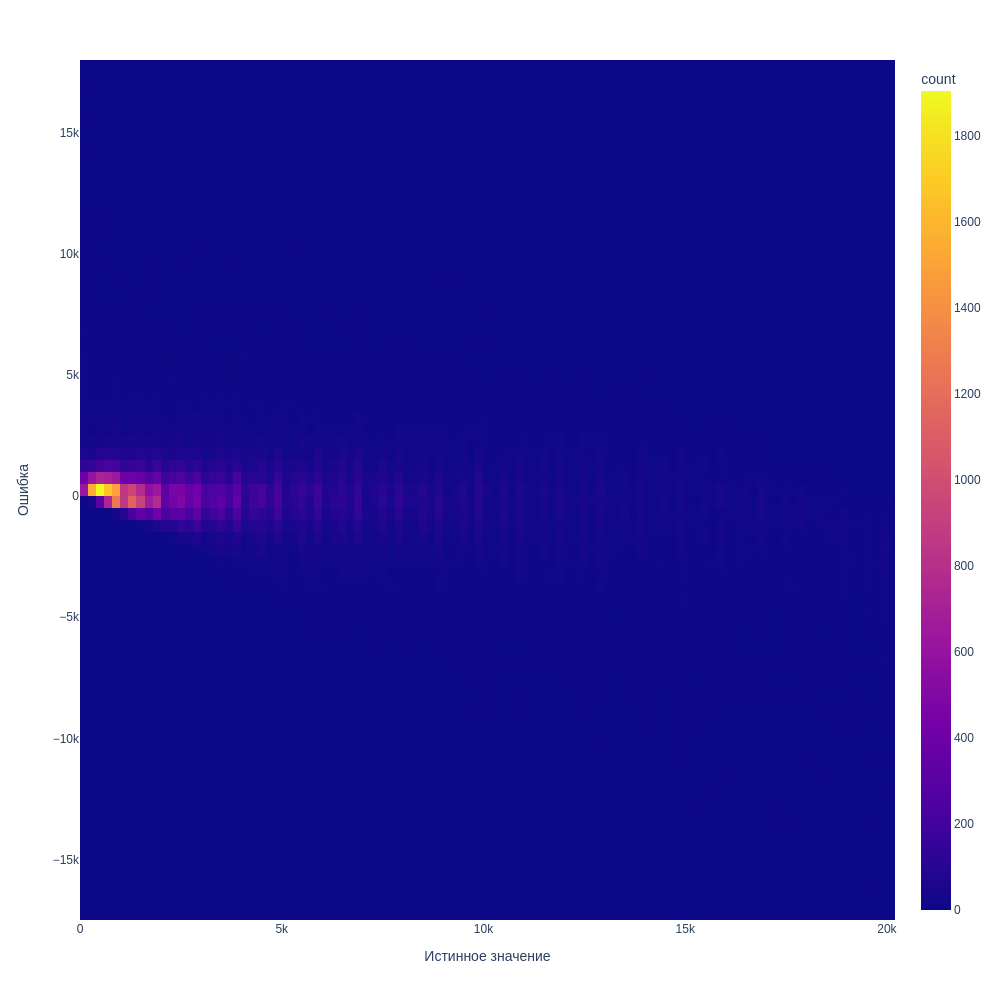

In [68]:
errors = pd.DataFrame(data={
    'true_value': y_test,
    'error': predictions['RandomForestRegressor'] - y_test
})

png_renderer.height = 1000

px.density_heatmap(
    errors,
    x='true_value',
    y='error',
    labels={
        'true_value': 'Истинное значение',
        'error': 'Ошибка'
    },
    nbinsx=100,
    nbinsy=100,
)

Масштаб по ошибке довольно большой. Построим violin-plot по ошибке.

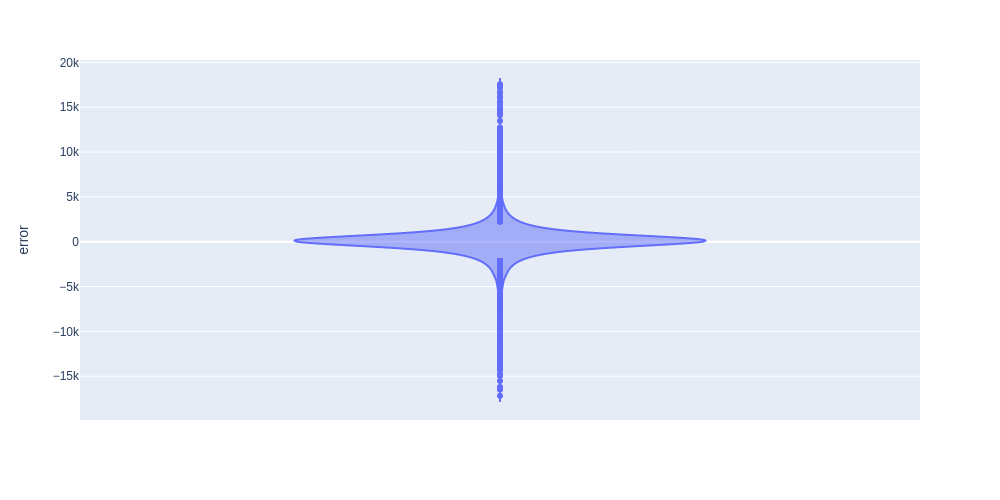

count    68720.000000
mean        29.297647
std       1646.697772
min     -17178.171569
25%       -486.784274
50%         91.838856
75%        619.292145
max      17564.506924
Name: error, dtype: float64

In [69]:
png_renderer.height = 500
display(px.violin(errors, y="error"))
errors['error'].describe()

У нас действительно есть огромные ошибки. Причём как в меньшую, так и в большую сторону. От -17k до +17k евро. Наверное, они и портят RMSE так сильно.

### Итоги

Не известно, на сколько критична скорость обучения модели. Это зависит от того, на сколько часто будут учить модель, и на какого размера выборках. Все модели предсказывают довольно быстро.

На тестировании моделей, все модели обучались на выборке из 274877 наблюдений и предсказывали на выборке из 68720 наблюдений.

С учётом недостатков остальных моделей, самая лучшая модель, которую удалось найти, это случайный лес, со следующими гиперпараметрами:

In [70]:
RandomForestRegressor(
    max_depth=20,
    n_estimators=51,
    random_state=0,
)

RandomForestRegressor(max_depth=20, n_estimators=51, random_state=0)

- Обучается за 1 минуту и 14 секунд.
- Предсказывает 2 секунды.
- RMSE = 1646.95.

Если приемлемо любое значение RMSE меньше 2500, то стоит обратить внимание на решающее дерево из-за его скорости обучения. Лучшие гиперпараметры, которых удалось добиться:

In [71]:
DecisionTreeRegressor(
    max_depth=13,
    random_state=0,
)

DecisionTreeRegressor(max_depth=13, random_state=0)

- Обучается гораздо быстрее остальных моделей. Всего 2 секунды.
- Предсказывает меньше секунды.
- RMSE гораздо хуже остальных моделей, но в пределах приемлемого. RMSE = 1927.54.

Третья модель, которую тестировали, это LightGBM. Её нельзя порекомендовать. RMSE немного хуже, чем у случайного леса, но обучается модель гораздо дольше остальных. Возможно, удалось бы получить RMSE лучше с другими гиперпараметрами, если бы не время обучения. Лучшие гиперпараметры, которые удалось найти:

In [72]:
LGBMRegressor(
    learning_rate=0.4375872112626925,
    num_leaves=28,
    random_state=0,
)

LGBMRegressor(learning_rate=0.4375872112626925, num_leaves=28, random_state=0)

- Обучается гораздо медленнее остальных моделей. 6 минут и 3 секунды.
- Предсказывает меньше секунды.
- RMSE немного хуже, чем у лидера. RMSE = 1682.35.

Стоит отметить, что даже у модели с лучшим RMSE присутствуют ошибки в 5-17k в обе стороны.

В данных присутствовали автомобили с нулевой ценой. Они были удалены из данных. Также присутствовали аномальные числовые значения. Они были заменены на нули, чтобы не удалять ещё больше данных. Так была сохранена информация о редких моделях автомобилей.